# Simulated Annealing

Simulated annealing is a process of approximating a gloabal optimisation by repeatedly heating a cooling a simulation over a timeframe. It is a general optimization algorithm that can be used for a variety of purposes, including protein dynamics. The algorithm is inspired by the process of annealing in metallurgy, in which a material is heated to a high temperature and then gradually cooled to improve its structural integrity.

In protein dynamics, the goal of simulated annealing is to find the lowest-energy conformation of a protein under certain conditions (e.g.after hyrdration or at a given pH), which corresponds to its most stable state. To do this, the algorithm starts with an initial guess for the protein's structureb (usually a PDB) and then iteratively makes random changes (or "moves") to the structure, with the probability of making each move determined by the current temperature. As the temperature is gradually lowered, the probability of making large changes to the structure decreases, and the algorithm becomes more likely to make small, local changes.

At high temperatures, the algorithm is able to explore a large number of different conformations of the protein, which allows it to escape from local energy minima and potentially find a global minimum. As the temperature is lowered, the algorithm becomes more likely to get stuck in a local minimum, but the minimum it finds is more likely to be the global minimum.

One of the key advantages of simulated annealing is that it can find the global minimum energy conformation of a protein even in the presence of multiple local minima. Another advantage is that it can be used to explore the conformational space of a protein even when the energy landscape is poorly understood, making it a widely used method in the field of computational protein dynamics.

# Load ligands and get them OpenFF ready

In [1]:
import openmm.app as app
from openff.toolkit.topology import Molecule

def rdkit_to_openmm(rdkit_mol, name="LIG"):
    """
    Convert an RDKit molecule to an OpenMM molecule.

    Parameters
    ----------
    rdkit_mol: rdkit.Chem.rdchem.Mol
        RDKit molecule to convert.
    name: str
        Molecule name.

    Returns
    -------
    omm_molecule: simtk.openmm.app.Modeller
        OpenMM modeller object holding the molecule of interest.
    """
    # convert RDKit to OpenFF
    off_mol = Molecule.from_rdkit(rdkit_mol, allow_undefined_stereo=True)

    # add name for molecule
    off_mol.name = name

    # add names for atoms
    element_counter_dict = {}
    for off_atom, rdkit_atom in zip(off_mol.atoms, rdkit_mol.GetAtoms()):
        element = rdkit_atom.GetSymbol()
        if element in element_counter_dict.keys():
            element_counter_dict[element] += 1
        else:
            element_counter_dict[element] = 1
        off_atom.name = element + str(element_counter_dict[element])

    # convert from OpenFF to OpenMM
    off_mol_topology = off_mol.to_topology()
    mol_topology = off_mol_topology.to_openmm()
    mol_positions = off_mol.conformers[0]

    # convert units from Ångström to nanometers
    # since OpenMM works in nm
    mol_positions = mol_positions.to("nanometers")

    # combine topology and positions in modeller object
    omm_mol = app.Modeller(mol_topology, mol_positions)

    return omm_mol

In [2]:
from rdkit import Chem
import os
#rdkit_ligand = Chem.MolFromMolFile('assets/cookbook/Ligands/LZU_ligand.sdf')

ligands_folder = 'assets/cookbook/Ligands'
ligand_files = [f for f in os.listdir(ligands_folder) if f.endswith('_h.sdf')]

for file in ligand_files:
    print(file)
    rdkit_ligand = Chem.MolFromMolFile(ligands_folder+"/"+file)
    ligand_name= "LIG"
    omm_ligand = rdkit_to_openmm(rdkit_ligand, ligand_name)

LZU_ligandwith_h.sdf


# Generate OpenFF topology

In [3]:
import openmm.app as app
from openff.toolkit.topology import Molecule

def rdkit_to_openmm(rdkit_mol, name="LIG"):
    """
    Convert an RDKit molecule to an OpenMM molecule.

    Parameters
    ----------
    rdkit_mol: rdkit.Chem.rdchem.Mol
        RDKit molecule to convert.
    name: str
        Molecule name.

    Returns
    -------
    omm_molecule: simtk.openmm.app.Modeller
        OpenMM modeller object holding the molecule of interest.
    """
    # convert RDKit to OpenFF
    off_mol = Molecule.from_rdkit(rdkit_mol, allow_undefined_stereo=True)

    # add name for molecule
    off_mol.name = name

    # add names for atoms
    element_counter_dict = {}
    for off_atom, rdkit_atom in zip(off_mol.atoms, rdkit_mol.GetAtoms()):
        element = rdkit_atom.GetSymbol()
        if element in element_counter_dict.keys():
            element_counter_dict[element] += 1
        else:
            element_counter_dict[element] = 1
        off_atom.name = element + str(element_counter_dict[element])

    # convert from OpenFF to OpenMM
    off_mol_topology = off_mol.to_topology()
    mol_topology = off_mol_topology.to_openmm()
    mol_positions = off_mol.conformers[0]

    # convert units from Ångström to nanometers
    # since OpenMM works in nm
    mol_positions = mol_positions.to("nanometers")

    # combine topology and positions in modeller object
    omm_mol = app.Modeller(mol_topology, mol_positions)

    return omm_mol, off_mol

In [5]:
from rdkit import Chem
import os

#rdkit_ligand = Chem.MolFromMolFile('assets/cookbook/Ligands/LZU_ligand.sdf')

# Load the hydrated ligand files
ligands_folder = 'assets/cookbook/Ligands'
ligand_files = [f for f in os.listdir(ligands_folder) if f.endswith('_h.sdf')]

# loop through each ligand file found
for file in ligand_files:
    rdkit_ligand = Chem.MolFromMolFile(ligands_folder+"/"+file)
    ligand_name= "LIG"
    omm_ligand, off_ligand = rdkit_to_openmm(rdkit_ligand, ligand_name)

# Clean protein PDB

In [6]:
from openmm.app import * 
from openmm import *
from openmm.unit import *
from openmm.openmm import *
from pdbfixer import PDBFixer
import subprocess

# PDB file that we will use as a starting structure
pdb_start = "assets/cookbook/4i1r.pdb"

# PDB file that we will use as the cleaned output structure
pdb_out = 'assets/cookbook/cleaned_output.pdb'

#output_capture = io.StringIO()

# Use amber4pdb to clean up records for use with amber forcefield
pdb4amber_result = subprocess.run(["pdb4amber", "--nohyd", "--dry", pdb_start],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )

with open(pdb_out, 'wb') as f:
    f.write(pdb4amber_result.stdout.encode("utf-8")) 

# Use reduce to add hydrogens according to ambers preferences    
#try:
#    out = subprocess.check_output(["reduce", "-build", "-nuclear", "assets/cookbook/cleaned_output.pdb"], stderr=subprocess.PIPE)
#except subprocess.CalledProcessError as e:
#    print("Error message from reduce:", e.stderr.decode())

# Use OpenMMs pdbfixer to fix some final issues that can crop up
fixed_pdb = PDBFixer(filename=pdb_out)
fixed_pdb.findMissingResidues()
fixed_pdb.findNonstandardResidues()
#fixer.replaceNonstandardResidues(
fixed_pdb.removeHeterogens(True) # comment to run with ligand
fixed_pdb.findMissingAtoms()
fixed_pdb.addMissingAtoms()
fixed_pdb.addMissingHydrogens(7.0)
PDBFile.writeFile(fixed_pdb.topology, fixed_pdb.positions, open(pdb_out, 'w'))

# Merge topologies of protien and ligand into a complex

In [7]:
import mdtraj as md
import numpy as np
def merge_protein_and_ligand(protein, ligand):
    """
    Merge two OpenMM objects.

    Parameters
    ----------
    protein: pdbfixer.pdbfixer.PDBFixer
        Protein to merge.
    ligand: simtk.openmm.app.Modeller
        Ligand to merge.

    Returns
    -------
    complex_topology: simtk.openmm.app.topology.Topology
        The merged topology.
    complex_positions: simtk.unit.quantity.Quantity
        The merged positions.
    """
    # combine topologies
    md_protein_topology = md.Topology.from_openmm(protein.topology)  # using mdtraj for protein top
    md_ligand_topology = md.Topology.from_openmm(ligand.topology)  # using mdtraj for ligand top
    md_complex_topology = md_protein_topology.join(md_ligand_topology)  # add them together
    complex_topology = md_complex_topology.to_openmm()

    # combine positions
    total_atoms = len(protein.positions) + len(ligand.positions)

    # create an array for storing all atom positions as tupels containing a value and a unit
    # called OpenMM Quantities
    complex_positions = unit.Quantity(np.zeros([total_atoms, 3]), unit=unit.nanometers)
    complex_positions[: len(protein.positions)] = protein.positions  # add protein positions
    complex_positions[len(protein.positions) :] = ligand.positions  # add ligand positions

    return complex_topology, complex_positions

In [8]:
complex_topology, complex_positions = merge_protein_and_ligand(fixed_pdb, omm_ligand)
print("Complex topology has", complex_topology.getNumAtoms(), "atoms.")
complex_topology

Complex topology has 5710 atoms.


/opt/conda/lib/python3.9/site-packages/openmm/unit/quantity.py:750: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  self._value[key] = value / self.unit


<Topology; 5 chains, 354 residues, 5710 atoms, 5762 bonds>

## Start anealing the complex

In [9]:

from tqdm import tqdm

from sys import stdout
from openmm.app import ForceField
from openff.toolkit.topology import Molecule, Topology
from openmmforcefields.generators import GAFFTemplateGenerator

# The forcefieild for the protein and solvent (if used)
protein_ff="amber14-all.xml" 
solvent_ff="amber14/tip3pfb.xml"
forcefield = app.ForceField(protein_ff, solvent_ff)

# Generate and add the forcefeild terms to the "forcefeild" function holdiding the protein and solver terms
gaff = GAFFTemplateGenerator(molecules=off_ligand)


forcefield.registerTemplateGenerator(gaff.generator)

# The modeller collects together the molecular data (positions and toplology) ready for combining with the forcefeild
modeller = app.Modeller(complex_topology, complex_positions)

# Optional code to extract periodic box from origional PDB
pdb_file = PDBFile("assets/cookbook/4i1r.pdb")
box_vectors = pdb_file.topology.getPeriodicBoxVectors()
modeller.topology.setPeriodicBoxVectors(box_vectors)


# setting of the chemical system
system = forcefield.createSystem(modeller.topology, nonbondedMethod=PME,
        nonbondedCutoff=1*nanometer, constraints=HBonds)

# settings for how bit the timestep should be
integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)

# Collect everthing together to make a simulation instance
simulation = Simulation(modeller.topology, system, integrator)

# File location to save output and how ofter to save
simulation.reporters.append(DCDReporter('assets/cookbook/first_output.dcd', 10))

output_file = 'simulation_data.csv'

# Report the physical properties to our CSV file every 300 steps
simulation.reporters.append(StateDataReporter(output_file, 300, step=True,
        potentialEnergy=True, temperature=True))

simulation.context.setPositions(modeller.positions)
simulation.minimizeEnergy()

# Progress bar to visualise how far we have run.
pbar = tqdm(total=100, unit=' step')

print("Running annealing simulation, this may take a few minutes")
# Define a function that runs the simulation
for i in range(100):
    integrator.setTemperature(3*(100-i)*kelvin)
    simulation.step(100)
    pbar.update(1)

# Close the progress bar
pbar.close()

  0% 0/100 [00:00<?, ? step/s]

Running annealing simulation, this may take a few minutes


100% 100/100 [01:53<00:00,  1.13s/ step]


In [14]:
import threading
import time
import pandas as pd

simulation_done = False

# Define a function that runs the simulation
def run_simulation():
    for i in range(100):
        integrator.setTemperature(3*(100-i)*kelvin)
        step_thread = threading.Thread(target=simulation.step, args=(300,))
        step_thread.start()
        step_thread.join()
    global simulation_done
    simulation_done = True

# Define a function that updates the output
def update_output():
    global simulation_done
    while not simulation_done:
        try:
            # Read the data from the output file into a Pandas DataFrame
            data = pd.read_csv(output_file)
            #display dataframe
            display(data.style.set_caption("Simulation Data"))
            time.sleep(0.5)
            clear_output(wait=True)
        except KeyboardInterrupt:
            break


# Create thread objects
simulation_thread = threading.Thread(target=run_simulation)
output_thread = threading.Thread(target=update_output)

# Start the threads
simulation_thread.start()
output_thread.start()

# Wait for the simulation thread to complete
simulation_thread.join()

,"#""Step""",Potential Energy (kJ/mole),Temperature (K)
0,300,-27163.688803,213.426163
1,600,-24338.166740,269.921111
2,900,-24432.869075,273.799387
3,1200,-24961.507152,273.713874
4,1500,-25237.699120,264.032746
5,1800,-25916.919175,260.251914
6,2100,-26612.725074,244.837928
7,2400,-26935.956388,240.025468
8,2700,-28010.309772,233.817111
9,3000,-28688.599567,220.920700


Exception in thread Thread-109:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_431/3077987522.py", line 27, in update_output
NameError: name 'clear_output' is not defined


# Ploting the output 

We can plot the output of the simulated annealing data to see if show the temperature (and potential energy) changed over time. The plot is over two axis and shows the temperature and PE raising and falling over each annealing cycle.

We will use Pandas to grab the CSV data we made before and then matplotlib to plot it nicely.

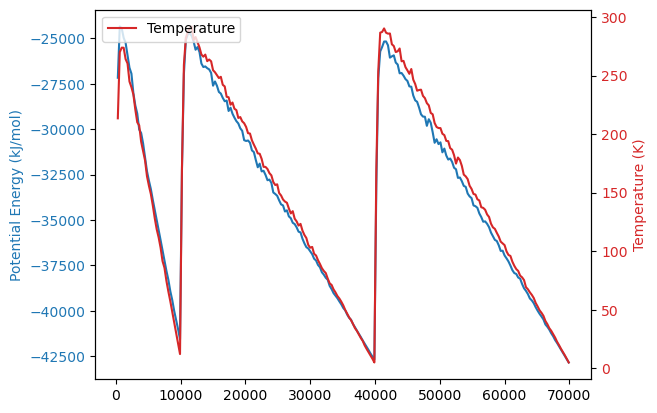

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Read in the data from the output file
df = pd.read_csv(output_file, comment="#", header=None, names=["Step","Potential Energy (kJ/mole)","Temperature (K)"])

# Extract the time, potential energy, and temperature columns
time = df["Step"]
potential_energy = df["Potential Energy (kJ/mole)"]
temperature = df["Temperature (K)"]

fig, ax1 = plt.subplots()

# Plot the potential energy on the left y-axis
ax1.plot(time, potential_energy, label='Potential Energy', color='tab:blue')
ax1.set_ylabel('Potential Energy (kJ/mol)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a twin y-axis for the temperature
ax2 = ax1.twinx()

# Plot the temperature on the right y-axis
ax2.plot(time, temperature, label='Temperature', color='tab:red')
ax2.set_ylabel('Temperature (K)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add a common x-axis label
plt.xlabel('Step')

# Add a legend
plt.legend(loc="upper left")

plt.show()